In [ ]:
import sys
import os

# Get parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add parent directory to sys.path
sys.path.append(parent_dir)

## Deploy pricer as modal app

In [11]:
import modal

In [12]:
!modal deploy service

- Creating objects...
\ Creating objects...
├── - Creating mount 
│   c:\Users\achil\llm_projects\llm_engineering\project\service.py: Uploaded 
│   0/1 files
└── - Creating mount PythonPackage:config_deploy: Uploaded 0/1 files
/ Creating objects...
├── | Creating mount 
│   c:\Users\achil\llm_projects\llm_engineering\project\service.py: Uploaded 
│   0/1 files
└── | Creating mount PythonPackage:config_deploy: Uploaded 0/1 files
\ Creating objects...
├── / Creating mount 
│   c:\Users\achil\llm_projects\llm_engineering\project\service.py: Uploaded 
│   0/1 files
└── / Creating mount PythonPackage:config_deploy: Uploaded 0/1 files
/ Creating objects...
├── \ Creating mount 
│   c:\Users\achil\llm_projects\llm_engineering\project\service.py: Uploaded 
│   0/1 files
└── \ Creating mount PythonPackage:config_deploy: Uploaded 0/1 files
\ Creating objects...
├── / Creating mount 
│   c:\Users\achil\llm_projects\llm_engineering\project\service.py: Finalizing 
│   index of 1 files
└── / Creatin

In [3]:
description = "1969 Chevrolet Camaro SS. Rotisserie restoration.Powder coated subframe, rear end and control arms. LS3 aluminum headed 350ci/350 hp engine. Street and Performance tuned port injection. Tremec 5 speed transmission. Centerforce clutch. Rock Valley stainless fuel tank. 4-Wheel disc brakes. Stainless fuel and brake lines. Tubular control arms. March serpentine pulley system. GPS Speedometer. AutoMeter Muscle gauges. Air Conditioning."

In [4]:
Pricer = modal.Cls.lookup('car-pricer','Pricer')
pricer = Pricer()
reply = pricer.price.remote(description)
print(reply)

75000.0


In [1]:
from loaders import ItemLoader
loader = ItemLoader()

train, test = loader.load_pickle(folder_name='train_test_sets')

In [2]:
train[0].prompt

"How much does this cost to the nearest dollar?\n\n1970 Ford Bronco\nBeach Ready Bronco 4x4 Restomod by Velocity Restorations The Velocity 1970 Ford Bronco Ranger Package is a head-turning classic that has been reborn and reimagined with fresh coastal vibes and rugged appeal. Balancing retro aesthetics with modern strength, this vintage Ford Bronco restomod blends the best of yesterday and today in every inch of its design. Wrapped in a dazzling two-tone Light Jade over Wimbledon White, this Bronco captures the essence of vintage adventure with the unmistakable charm of the Ranger Package. The exterior's retro stripes and two-tone color scheme are complemented by 33-inch Cooper tires and 17-inch painted steel wheels, giving the Bronco a vintage feel and a sturdy presence on any terrain. The interior continues the theme of elegance and refinement, featuring Velocity's exclusive trim and premium Ranger-upgraded upholstery. Each detail is thoughtfully designed for comfort, blending authen

## Create Chroma datastore

In [1]:
%load_ext autoreload
%autoreload 2

import chromadb
from config_deploy import DB, EMBEDDING
from sentence_transformers import SentenceTransformer
import numpy as np

In [11]:
client = chromadb.PersistentClient(path=DB)

In [12]:
# check if collection exists. Delete it if it does
collection_name = 'cars'
existing_collection_names = [collection.name for collection in client.list_collections()]
if collection_name in existing_collection_names:
    client.delete_collection(collection_name)
    print(f'deleted existing collection: {collection_name}')
    
collection = client.create_collection(collection_name)

deleted existing collection: cars


In [13]:
model = SentenceTransformer(EMBEDDING)
vector = model.encode('This is a test')

In [14]:
len(vector)

384

In [12]:
def get_description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

get_description(train[0])

"1970 Ford Bronco\nBeach Ready Bronco 4x4 Restomod by Velocity Restorations The Velocity 1970 Ford Bronco Ranger Package is a head-turning classic that has been reborn and reimagined with fresh coastal vibes and rugged appeal. Balancing retro aesthetics with modern strength, this vintage Ford Bronco restomod blends the best of yesterday and today in every inch of its design. Wrapped in a dazzling two-tone Light Jade over Wimbledon White, this Bronco captures the essence of vintage adventure with the unmistakable charm of the Ranger Package. The exterior's retro stripes and two-tone color scheme are complemented by 33-inch Cooper tires and 17-inch painted steel wheels, giving the Bronco a vintage feel and a sturdy presence on any terrain. The interior continues the theme of elegance and refinement, featuring Velocity's exclusive trim and premium Ranger-upgraded upholstery. Each detail is thoughtfully designed for comfort, blending authentic style with a level of luxury uncommon in early

In [16]:
import math
from tqdm import tqdm

STEP_SIZE = 100
DATA_SIZE = len(train)

def add_collection(data_size: int=DATA_SIZE, step_size: int=STEP_SIZE) -> None:
    """Adds training set to ChromaDB as a collection.

    Args:
        data_size (int, optional): _description_. Defaults to DATA_SIZE.
        step_size (int, optional): _description_. Defaults to STEP_SIZE.
    """
    quotient = math.floor(data_size / step_size) # number of full loops through the data
    remainder = data_size % step_size # size of data remaining

    for i in tqdm(range(0, data_size, step_size)):
        next_step = step_size if i + step_size <= data_size - remainder else remainder
        offset = i + next_step
        
        documents = [get_description(item) for item in train[i:offset]]
        vectors = model.encode(documents).astype(float).tolist()
        metadatas = [{'category': item.category, 'price': item.price} for item in train[i:offset]]
        ids = [f'doc_{idx}' for idx in range(i, offset)]
        collection.add(
            ids=ids,
            documents=documents,
            embeddings=vectors,
            metadatas=metadatas
        )
        
add_collection()

100%|██████████| 15/15 [01:26<00:00,  5.76s/it]


## Visualize the embeddings

In [18]:
MAX_DATAPOINTS = len(train)

result = collection.get(include=['embeddings', 'documents', 'metadatas'], limit=MAX_DATAPOINTS)
vectors = np.array(result['embeddings'])
documents = result['documents']
categories = [metadata['category'] for metadata in result['metadatas']]

In [26]:
CATEGORIES = list(set(categories))
CATEGORIES

['1969_ford_mustang',
 '1967_chevrolet_camaro',
 '1966_ford_mustang',
 '1974_ford_bronco',
 '1975_ford_bronco',
 '1970_ford_bronco',
 '1968_ford_mustang',
 '1973_ford_bronco',
 '1968_chevrolet_camaro',
 '1970_ford_mustang',
 '1970_chevrolet_camaro',
 '1972_chevrolet_camaro',
 '1977_ford_bronco',
 '1971_ford_bronco',
 '1969_ford_bronco',
 '1965_ford_mustang',
 '1966_ford_bronco',
 '1969_chevrolet_camaro',
 '1967_ford_mustang',
 '1970_dodge_charger',
 '1972_ford_bronco',
 '1971_ford_mustang',
 '1969_dodge_charger',
 '1971_chevrolet_camaro',
 '1967_ford_bronco',
 '1976_ford_bronco',
 '1968_ford_bronco',
 '1968_dodge_charger']

In [29]:
COLORS = ['yellow', 'red', 'darkgoldenrod','green','chartreuse','darkgreen','gold','forestgreen',
          'darkred','goldenrod','firebrick','maroon','lightgreen','lime','limegreen','khaki','mediumseagreen',
          'orangered','moccasin','mediumblue','mediumspringgreen','navajowhite','skyblue','tomato','yellowgreen',
          'olive','palegreen','turquoise']
colors = [COLORS[CATEGORIES.index(c)] for c in categories]

In [28]:
# make 2D chart
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from config_deploy import SEED

tsne = TSNE(n_components=2, random_state=SEED, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

In [30]:

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=3, color=colors, opacity=0.7),
)])

fig.update_layout(
    title='2D Chroma Vectorstore Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Build RAG pipeline

In [2]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('cars')

In [8]:
model = SentenceTransformer(EMBEDDING)

In [9]:
def make_context(similars, prices):
    message = "To provide some context, here are some other cars that are similar to the car you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related car:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [10]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of classic cars. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [13]:
get_description(test[0])

'1969 Chevrolet Camaro\n1969 Chevrolet Camaro SS Convertible. 396 Automatic Body off restoration. Documented matching numbers. Original documents include. Protection plate, original title. Original invoice and more. Rated #1 show quality. Options PS PB Power Top Rear shoulder seat belts. No AC -Vehicle is on consignment and at our clients home -Please Call First and talk to a rep at EXT 1 -Showroom is by appointment only Please Call -If you would like a FREE Listing please visit our consignment page or Call Category 1969_chevrolet_camaro'

In [14]:
def get_vector(item):
    return model.encode([get_description(item)])

In [15]:
# format of result from querying ChromaDB for top 3 most similar to sample description
collection.query(query_embeddings=get_vector(test[0]).astype(float).tolist(), n_results=3)

{'ids': [['doc_181', 'doc_248', 'doc_828']],
 'embeddings': None,
 'documents': [['1969 Chevrolet Camaro\n1969 Chevrolet Camaro RS/SS Gorgeous restored muscle car! •Replacement 396cid engine •Less than 2500 miles •Th400 auto transmission •Power Steering •Power cross drilled/slotted disc brakes •Vintage air conditioning •Nice exterior Tuxedo black paint •Straight body •Clean black houndstooth interior •Center console/Seatbelts •American racing wheel/tire package •Flowmaster Dual exhaust system •Suspension feels great •Chrome/Glass/Trim good •Weatherstripping good •Clean title Delivery is also available by request Text your zip code for a quote Text gets quicker response Shown by appointment ONLY! MGM NEW LOW PRICE-BUY IT NOW! Category 1969_chevrolet_camaro',
   '1969 Chevrolet Camaro\n1969 Camaro Convertible, RS/SS Clone, 396/350 Motor, Muncie 4 Speed, Posi Traction 373 Gear, 4 Wheel Disc Brakes, No A/C, No Power Top, Completely Restored Last Year, Absolutely No Rust, Runs and Drives Go

In [16]:
TOP_K = 5
def find_similars(item, n_results=TOP_K):
    results = collection.query(query_embeddings=get_vector(item).astype(float).tolist(), n_results=n_results)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [17]:
documents, prices = find_similars(test[0])

In [18]:
print(make_context(documents, prices))

To provide some context, here are some other cars that are similar to the car you need to estimate.

Potentially related car:
1969 Chevrolet Camaro
1969 Chevrolet Camaro RS/SS Gorgeous restored muscle car! •Replacement 396cid engine •Less than 2500 miles •Th400 auto transmission •Power Steering •Power cross drilled/slotted disc brakes •Vintage air conditioning •Nice exterior Tuxedo black paint •Straight body •Clean black houndstooth interior •Center console/Seatbelts •American racing wheel/tire package •Flowmaster Dual exhaust system •Suspension feels great •Chrome/Glass/Trim good •Weatherstripping good •Clean title Delivery is also available by request Text your zip code for a quote Text gets quicker response Shown by appointment ONLY! MGM NEW LOW PRICE-BUY IT NOW! Category 1969_chevrolet_camaro
Price is $59994.00

Potentially related car:
1969 Chevrolet Camaro
1969 Camaro Convertible, RS/SS Clone, 396/350 Motor, Muncie 4 Speed, Posi Traction 373 Gear, 4 Wheel Disc Brakes, No A/C, No 

In [19]:
print(messages_for(test[0], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of classic cars. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other cars that are similar to the car you need to estimate.\n\nPotentially related car:\n1969 Chevrolet Camaro\n1969 Chevrolet Camaro RS/SS Gorgeous restored muscle car! •Replacement 396cid engine •Less than 2500 miles •Th400 auto transmission •Power Steering •Power cross drilled/slotted disc brakes •Vintage air conditioning •Nice exterior Tuxedo black paint •Straight body •Clean black houndstooth interior •Center console/Seatbelts •American racing wheel/tire package •Flowmaster Dual exhaust system •Suspension feels great •Chrome/Glass/Trim good •Weatherstripping good •Clean title Delivery is also available by request Text your zip code for a quote Text gets quicker response Shown by appointment ONLY! MGM NEW LOW PRICE-BUY IT NOW! Category 1969_chevrolet_camaro\nPrice is $59994.00\n\nPotentially related ca

In [22]:
from openai import OpenAI
from utils import Utils
from config_deploy import OPENAI_API_KEY, MAX_NEW_TOKENS, SEED

util = Utils()
openai = OpenAI()
openai.api_key = OPENAI_API_KEY

# function for gpt-4o-mini
def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=SEED,
        max_tokens=MAX_NEW_TOKENS
    )
    reply = response.choices[0].message.content
    return util.get_price(reply)

In [23]:
gpt_4o_mini_rag(test[0])

74900.0

In [24]:
test[1].price

39995.0

1: Guess: $74,900.00 Truth: $102,995.00 Error: $28,095.00 SLE: 0.10 Item: 1969 Chevrolet Camaro
2: Guess: $57,900.00 Truth: $39,995.00 Error: $17,905.00 SLE: 0.14 Item: 1967 Chevrolet Camaro
3: Guess: $12,000.00 Truth: $12,950.00 Error: $950.00 SLE: 0.01 Item: 1968 Chevrolet Camaro
4: Guess: $139,000.00 Truth: $115,000.00 Error: $24,000.00 SLE: 0.04 Item: 1968 Chevrolet Camaro SS
5: Guess: $155,000.00 Truth: $125,000.00 Error: $30,000.00 SLE: 0.05 Item: 1967 Ford Mustang
6: Guess: $75,000.00 Truth: $65,000.00 Error: $10,000.00 SLE: 0.02 Item: 1966 Ford Mustang
7: Guess: $59,900.00 Truth: $57,995.00 Error: $1,905.00 SLE: 0.00 Item: 1967 Chevrolet Camaro
8: Guess: $49,500.00 Truth: $49,500.00 Error: $0.00 SLE: 0.00 Item: 1975 Ford Bronco
9: Guess: $49,995.00 Truth: $64,900.00 Error: $14,905.00 SLE: 0.07 Item: 1968 Chevrolet Camaro
10: Guess: $36,000.00 Truth: $36,000.00 Error: $0.00 SLE: 0.00 Item: 1967 Ford Bronco
11: Guess: $64,950.00 Truth: $44,950.00 Error: $20,000.00 SLE: 0.14 Item:

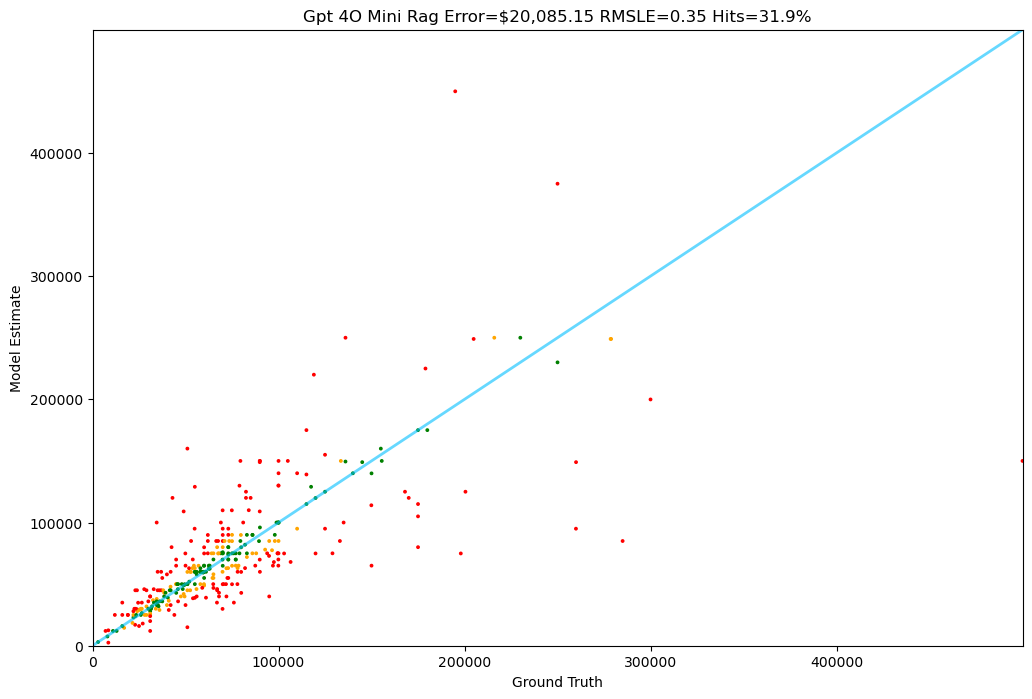

In [26]:
from testing import Tester
# evaluate GPT 4o mini with RAG 
Tester.test(gpt_4o_mini_rag, test)

## Train Random Forest model on embeddings

In [6]:
# load test

import numpy as np
from loaders import ItemLoader
from config_deploy import DB, COLLECTION, SEED
import chromadb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

l = ItemLoader()
test = l.load_pickle('train_test_sets')[1] # only retrieve test 
print(f'test size: {len(test)}')

test size: 339


In [7]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection(COLLECTION)

In [ ]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [3]:
# Train random forest model

rf_model = RandomForestRegressor(n_estimators=100, random_state=SEED)
rf_model.fit(vectors, prices)

RandomForestRegressor(random_state=42)

In [4]:
# Save the model to a file

joblib.dump(rf_model, 'models/random_forest_model.pkl')

['models/random_forest_model.pkl']

In [3]:
# Load it back in again

rf_model = joblib.load('models/random_forest_model.pkl')

In [3]:
from agents.specialist_agent import SpecialistAgent
from agents.rag_agent import RagAgent
from agents.rf_agent import RandomForestAgent

In [4]:
# Instantiate models that will be used in ensemble pricer model.
specialist = SpecialistAgent()
rag = RagAgent(collection)
random_forest = RandomForestAgent()

In [9]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [7]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $86,582.67 Truth: $102,995.00 Error: $16,412.33 SLE: 0.03 Item: 1969 Chevrolet Camaro
2: Guess: $71,064.61 Truth: $39,995.00 Error: $31,069.61 SLE: 0.33 Item: 1967 Chevrolet Camaro
3: Guess: $63,408.67 Truth: $12,950.00 Error: $50,458.67 SLE: 2.52 Item: 1968 Chevrolet Camaro
4: Guess: $85,092.50 Truth: $115,000.00 Error: $29,907.50 SLE: 0.09 Item: 1968 Chevrolet Camaro SS
5: Guess: $63,869.82 Truth: $125,000.00 Error: $61,130.18 SLE: 0.45 Item: 1967 Ford Mustang
6: Guess: $46,483.13 Truth: $65,000.00 Error: $18,516.87 SLE: 0.11 Item: 1966 Ford Mustang
7: Guess: $73,440.85 Truth: $57,995.00 Error: $15,445.85 SLE: 0.06 Item: 1967 Chevrolet Camaro
8: Guess: $88,199.04 Truth: $49,500.00 Error: $38,699.04 SLE: 0.33 Item: 1975 Ford Bronco
9: Guess: $59,729.36 Truth: $64,900.00 Error: $5,170.64 SLE: 0.01 Item: 1968 Chevrolet Camaro
10: Guess: $91,140.39 Truth: $36,000.00 Error: $55,140.39 SLE: 0.86 Item: 1967 Ford Bronco
11: Guess: $56,340.16 Truth: $44,950.00 Error: $11,390.16 SLE:

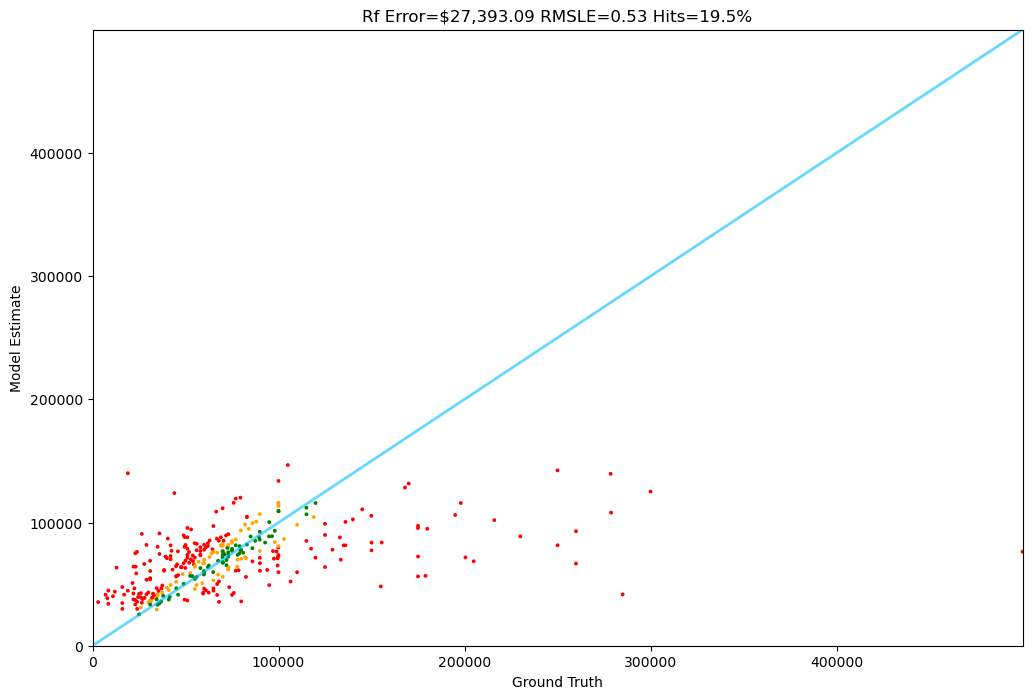

In [10]:
# doesn't outperform baseline LR model. Use TFIDF based RF model from baseline_models instead. 
from testing import Tester
Tester.test(rf, test)

In [5]:
desc = """1967 Camaro RS with Hideaway Headlights!!!

1967 Camaro RS

Built 350 V8, Automatic Trans, Headers, Power Steering, Power Disc Brakes, RS Headaway Head Lights, Black Bucket Seat Interior with Center Console and Shifter, American Racing Torque Thrust II Chrome Wheels with Raised White Letter Tires, and much more!

This is an absolutely Stunning Camaro! It is finished in a Beautiful Rare Madeira Maroon Metallic with Black Stripe over a Black Interior! Car also has Laser Straight Lines and Awesome Stance!! This car is sure to be the Envy of the Neighborhood and a hit at Car Shows!

FaceTime Walk Around and Test Drive available upon request!!!

Our Service Department can add any options you like!!! We are authorized Vintage AC, RideTech Suspension, CVF Racing, and Dakota Digital Gauges Authorized Dealer!!!

Don't miss your chance to own this Iconic American Muscle Car at a Great Price! We can assist with obtaining financing and can have this car shipped right to your front door!"""

In [7]:
print(specialist.price(desc))
print(rag.price(desc))
print(random_forest.price(desc))

59900.0
51900.0
58691.23


In [8]:
# load test set
from loaders import ItemLoader
loader = ItemLoader()

test = loader.load_pickle(folder_name='train_test_sets')[1]

In [11]:
from tqdm import tqdm
# collect price predictions from all three models for test set
specialists = []
rags = []
random_forests = []
prices = []
for item in tqdm(test):
    text = description(item)
    specialists.append(specialist.price(text))
    rags.append(rag.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|██████████| 339/339 [15:25<00:00,  2.73s/it] 


In [12]:
# Create Ensemble
import pandas as pd

X = pd.DataFrame({
    'Specialist': specialists,
    'Rag': rags,
    'RandomForest': random_forests
})

# Convert y to a Series
y = pd.Series(prices)

In [13]:
# Train a Linear Regression
from sklearn.linear_model import LinearRegression

np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.23
Rag: 0.63
RandomForest: 0.27
Intercept=-5756.25


In [14]:
y_pred = lr.predict(X)

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(y, y_pred)

rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R-squared: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")

R-squared: 0.68
RMSE: 30670.12


In [17]:
import joblib
# Save ensemble model
joblib.dump(lr, 'models/ensemble_model.pkl')

['models/ensemble_model.pkl']

In [20]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [21]:
ensemble.price(desc)

55923.81165350747

In [22]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

1: Guess: $79,222.66 Truth: $102,995.00 Error: $23,772.34 SLE: 0.07 Item: 1969 Chevrolet Camaro
2: Guess: $56,611.23 Truth: $39,995.00 Error: $16,616.23 SLE: 0.12 Item: 1967 Chevrolet Camaro
3: Guess: $25,284.59 Truth: $12,950.00 Error: $12,334.59 SLE: 0.45 Item: 1968 Chevrolet Camaro
4: Guess: $155,494.17 Truth: $115,000.00 Error: $40,494.17 SLE: 0.09 Item: 1968 Chevrolet Camaro SS
5: Guess: $149,984.38 Truth: $125,000.00 Error: $24,984.38 SLE: 0.03 Item: 1967 Ford Mustang
6: Guess: $59,654.30 Truth: $65,000.00 Error: $5,345.70 SLE: 0.01 Item: 1966 Ford Mustang
7: Guess: $62,747.71 Truth: $57,995.00 Error: $4,752.71 SLE: 0.01 Item: 1967 Chevrolet Camaro
8: Guess: $58,181.26 Truth: $49,500.00 Error: $8,681.26 SLE: 0.03 Item: 1975 Ford Bronco
9: Guess: $62,322.22 Truth: $64,900.00 Error: $2,577.78 SLE: 0.00 Item: 1968 Chevrolet Camaro
10: Guess: $38,742.61 Truth: $36,000.00 Error: $2,742.61 SLE: 0.01 Item: 1967 Ford Bronco
11: Guess: $68,878.47 Truth: $44,950.00 Error: $23,928.47 SLE: 0

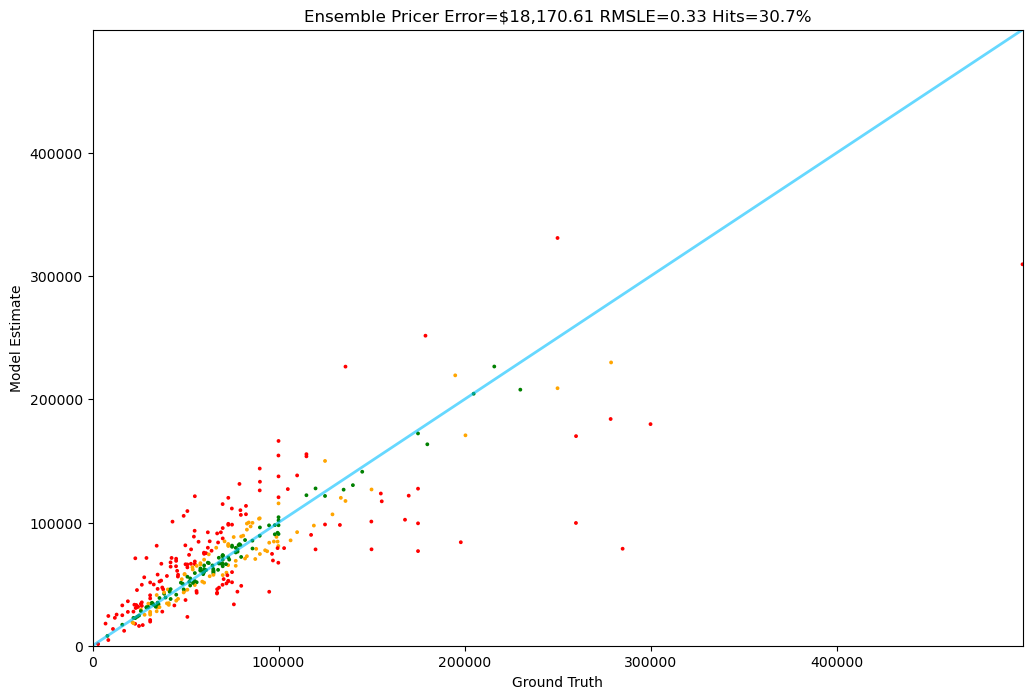

In [24]:
from testing import Tester
Tester.test(ensemble_pricer, test)